## full modeling pipeline

- define linear state space model to generate data
- define RNN and train
- evaluate results


in case the local modules are not found, set current working directory correctly:
```bash
import sys
import os
# Add the root directory of your repository to the Python path
sys.path.append(os.path.abspath('<path to your repo>/dynamic_system_identification_with_ml'))

```

In [1]:
import sys
import os
# Add the root directory of your repository to the Python path
sys.path.append(os.path.abspath('/mnt/c/Projects/github/dynamic_system_identification_with_ml'))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from system_models.statespacesimulator import StateSpaceSimulator

# Continuous-time dynamical system defined by state space model
A=np.matrix([[0, 1],[- 0.1, -0.000001]])
B=np.matrix([[0],[1]])
C=np.matrix([[1, 0]])

time_steps = 500
sampling=0.5
print('time sequence length:'+str(sampling*time_steps))

system = StateSpaceSimulator(A,B,C,time_steps, sampling)

time sequence length:250.0


### Create the training data

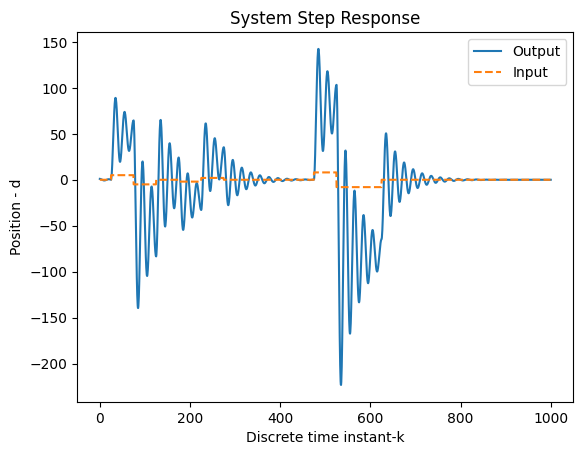

(1, 2001, 2)
(1, 2001, 1)


In [3]:
#define an input sequence for the simulation
input_seq_train=np.random.rand(time_steps*4,1)*0-0.5*0
input_seq_train[50:150] = 5
input_seq_train[150:250] = -5
input_seq_train[250:350] = 0
input_seq_train[350:450] = -2
input_seq_train[450:550] = 2
input_seq_train[950:1050] = 8
input_seq_train[1050:1250] = -8
#define an initial state for simulation
x0_train=np.random.rand(2,1)

system.initalize(x0_train,input_seq_train)
state,output,time = system.simulate()
system.plot_sys_resp(time,output)
trainX,output_train = system.prepare_model_training()

print(trainX.shape)
print(output_train.shape)


### Validation Data

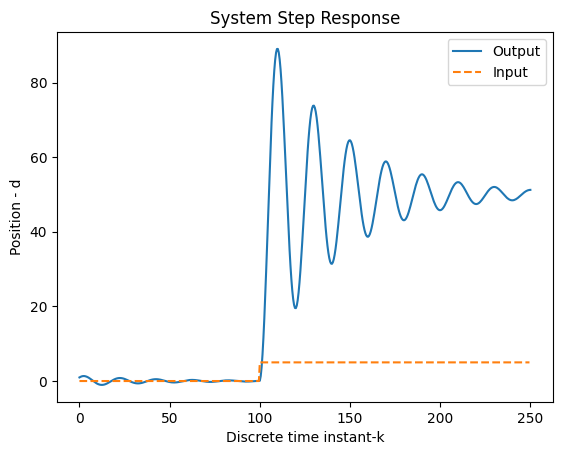

In [4]:
# new random input sequence
input_seq_validate=np.random.rand(time_steps,1)*0-0.5*0
input_seq_validate[200:]=5
# new random initial condition
x0_validate=np.random.rand(2,1)

system.initalize(x0_validate,input_seq_validate)
state,output,time = system.simulate()
system.plot_sys_resp(time,output)
validateX,output_validate = system.prepare_model_training()

### Test Data

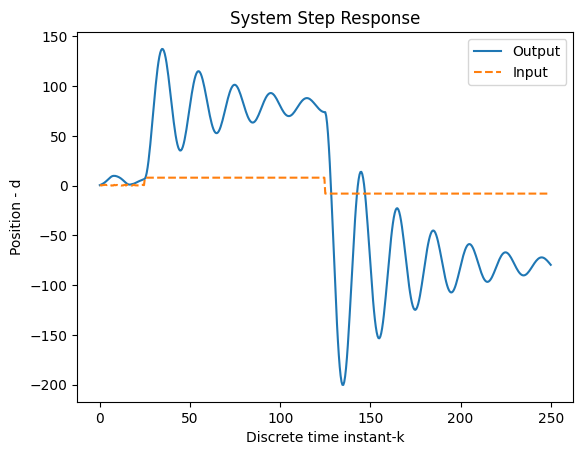

In [5]:
# new random input sequence
input_seq_test=np.random.rand(time_steps,1)
input_seq_test[50:250]=8
input_seq_test[250:]=-8
# new random initial condition
x0_test=np.random.rand(2,1)

system.initalize(x0_test,input_seq_test)
state,output,time = system.simulate()
system.plot_sys_resp(time,output)
testX,output_test = system.prepare_model_training()

In [6]:
np.save("../data/trainX.npy", trainX)
np.save("../data/output_train.npy", output_train)
np.save("../data/validateX.npy", validateX)
np.save("../data/output_validate.npy", output_validate)
np.save("../data/testX.npy", testX)
np.save("../data/output_test.npy", output_test)

### Define and train the model

In [7]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Disable GPU

2025-02-21 00:16:57.087099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740093418.781554   12252 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740093419.274883   12252 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 00:17:03.279486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1740093488.585751   12252 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with 

In [8]:
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

In [10]:
# recommended to avoid warning!
#model = Sequential([
#    Input(shape=(timesteps, features)),  # Define input explicitly
#    LSTM(64, return_sequences=True),
#    LSTM(32),
#    Dense(1, activation='linear')
#])

In [11]:
with tf.device('CPU:0'):
    # Define Model
    model = Sequential()
    #model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True,activation='sigmoid'))
    model.add(LSTM(32, input_shape=(10, trainX.shape[2]), return_sequences=True,activation='sigmoid'))
    model.add(TimeDistributed(Dense(1)))  # Output at each time step

    # Compile Model
    model.compile(optimizer=RMSprop(learning_rate=0.01), loss='mean_squared_error', metrics=['mse'])
    #model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mse'])

    # Define Checkpoint (Fixed Path and Deprecation Warning)
    filepath = r"./models/weights-{epoch:02d}-{val_loss:.6f}.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                save_best_only=False, save_weights_only=False, 
                                mode='auto', save_freq='epoch')

    # Train Model
    callbacks_list = [checkpoint]
    callback_list = []

/mnt/c/Projects/github/dynamic_system_identification_with_ml/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
with tf.device('CPU:0'):
    history = model.fit(trainX, output_train, epochs=1000, batch_size=32, 
                    callbacks=callbacks_list, validation_data=(validateX, output_validate), verbose=2)


In [ ]:
trainPredict = model.predict(trainX)
validatePredict = model.predict(validateX)
# plot the predicted and the "true" (test) outputs
time_plot=range(1,len(trainPredict[0])+1)
plt.figure()
plt.plot(time_plot,output_train[0,:], label='Real output (train)')
plt.plot(time_plot,trainPredict[0,:,0],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('responseLSTM32.png')
plt.show()

time_plot=range(1,time_steps+2)
plt.figure()
plt.plot(time_plot,output_validate[0,:], label='Real output (validate)')
plt.plot(time_plot,validatePredict[0,:,0],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('responseLSTM32.png')
plt.show()

In [ ]:
# load the model with the smallest validation loss
#model.load_weights("weights-1997-1.878475.hdf5")

# use the test data to predict the model response
testPredict = model.predict(testX)

# plot the predicted and the "true" (test) outputs
time_plot=range(1,time_steps+2)
plt.figure()
plt.plot(time_plot,output_test[0,:], label='Real output')
plt.plot(time_plot,testPredict[0,:,0],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('responseLSTM32.png')
plt.show()

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig('lossLSTM32.png')
plt.show()

